# **Avance 2. Series de tiempo univariadas:**
# **Caso volumen de acopio nacional de leche cruda** 🐮
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Julieth Karina Vegar Barajas](jvejar@unal.edu.co)

---
**Nota 1:** Este cuaderno contiene código de R y python cuyos objetos interáctuan entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

**Nota 3:** Por simplicidad, las series se separaron en dos cuadernos. En este se encuentran todos los procedimientos relacionados a la serie de [Volumen de acopio de leche mensual en el país](https://uspleche.minagricultura.gov.co/documentos.html) con corte a Diciembre de 2023.

---

### **Paquetes utilizados**

In [100]:
# Este módulo es usado para correr código de R y hacer que los objetos de R interactuén con python
%load_ext rpy2.ipython

# Manejo de datos en general
import pandas as pd
import numpy as np

# Para poder graficar
import matplotlib.pyplot as plot

# Construcción del árbol de decisión
from sklearn.tree import DecisionTreeRegressor

# Tuning del árbol
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Medidas de precisión
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Para el ajuste de hiperparámetros
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Para mostrar la estructura del árbol
from sklearn.tree import plot_tree

# Para que no aparezcan alertas
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 🐮 **Lectura de los datos**

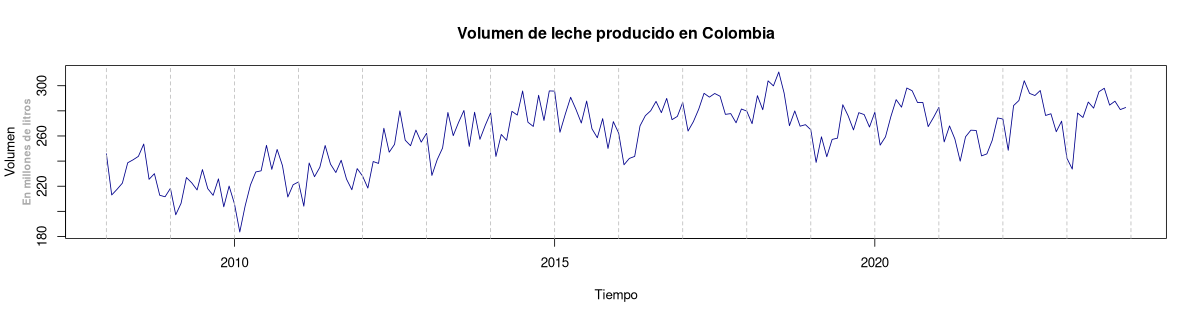

In [10]:
%%R -w 15 -h 4 --units in -r 80
Ruta = '/home/mendivenson/Documents/4) Series de Tiempo Univariadas (SdTU)/2) Espacio de trabajo/' # Cambie esta ruta a la que corresponda
source(paste0(Ruta,'Script análisis/Leche: Lectura de datos.R'))
abline(v = 2008:2024, col = 'gray', lty = 'dashed')

---

# 🐮 **Análisis descriptivo**

En el avance 1, se realizaron los respectivos análisis de homocedasticidad, tendencia y estacionalidad para cada una de las series obteniendo los siguientes resultados:

## 🐮🐮 **Estabilización de la varianza**

Al buscar un $\lambda$ para la transformación Box Cox encontramos que el que maximiza la log verosimilitud es $3.15$  apróximadamente por lo que se aplica la transformación obteniendo lo siguiente:

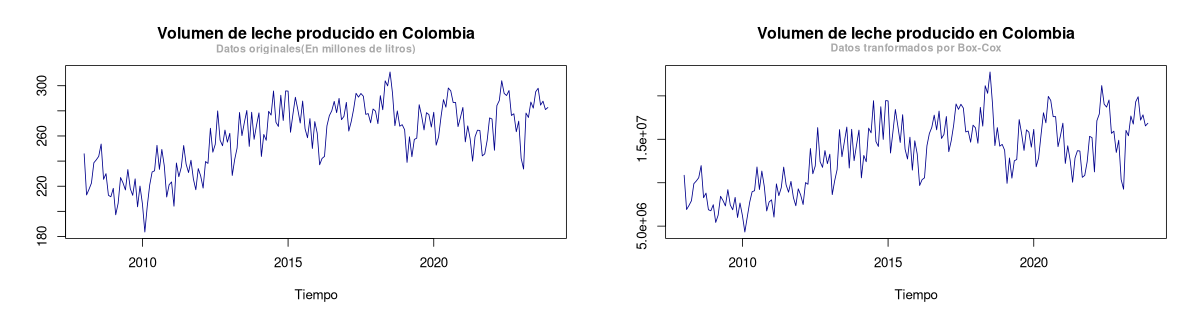

In [11]:
%%R -w 15 -h 4 --units in -r 80
source(paste0(Ruta,'Script análisis/Leche: Análisis de varianza.R'))

Como la serie no cambia realmente de estructura sino que aumenta de forma drástica su escala, se decide no aplicar la transformación Box Cox.

## 🐮🐮 **Eliminación de tendencia**

La serie claramente presenta cierta tendencia no completamente lineal por lo que se decide aplicar suavizamiento kernel:

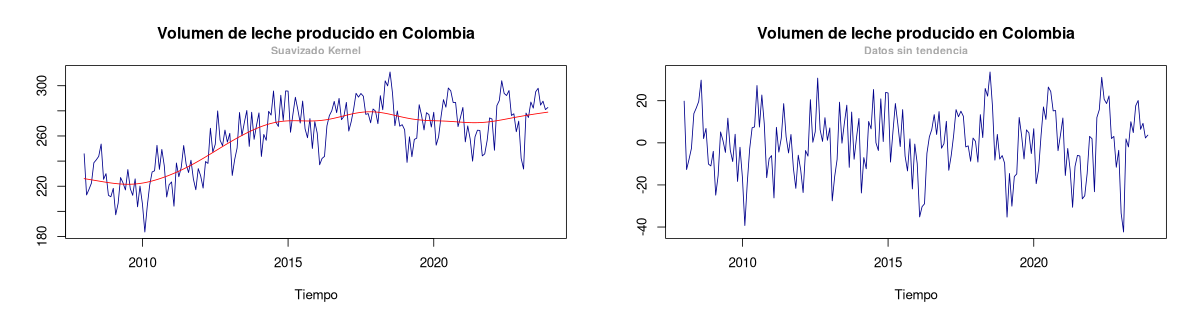

In [12]:
%%R -w 15 -h 4 --units in -r 80 -o  leche
# -o leche pasa el objeto leche a python como un array: Este objeto se utilizará en los árboles de decisión
# pues estos on útiles para datos sin tendencia
source(paste0(Ruta,'Script análisis/Leche: Eliminación de la tendencia.R'))

## 🐮🐮 **Análisis de estacionalidad**

En este caso, se utiizaron distintas herramientas gráficas para determinar la estacionalidad de la serie. Sin embargo, aquí presentamos únicamente el periodograma, las subseries y el gráfico de retardos:

### 🐮🐮🐮 **Gráfico de retardos**

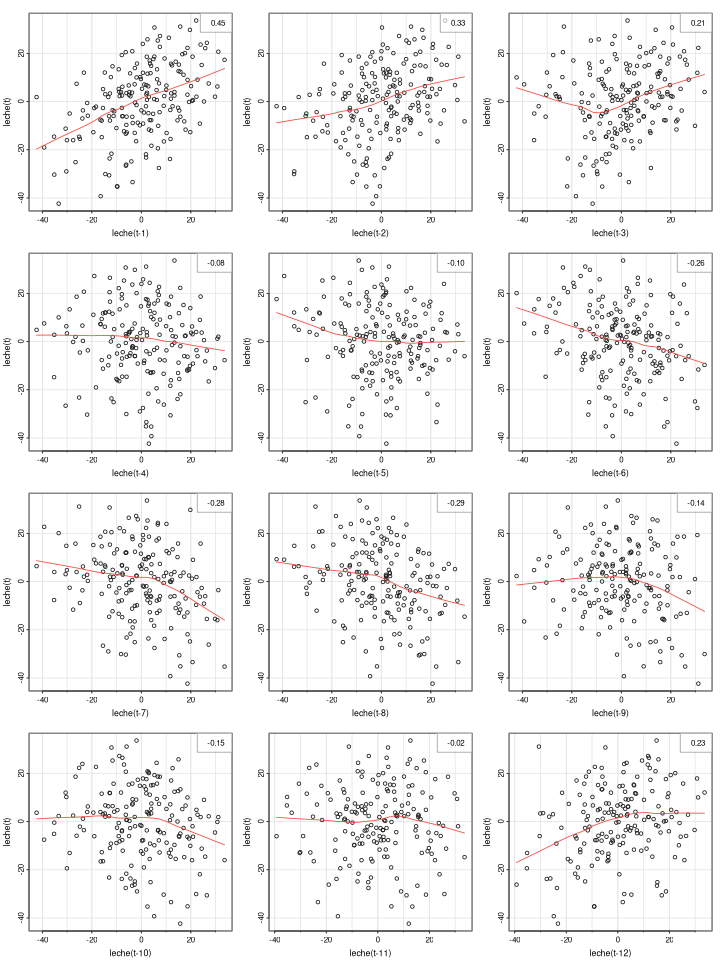

In [13]:
%%R -w 9 -h 12 --units in -r 80
astsa::lag1.plot(leche,12,corr = T, )

### 🐮🐮🐮 **Subseries mensuales**

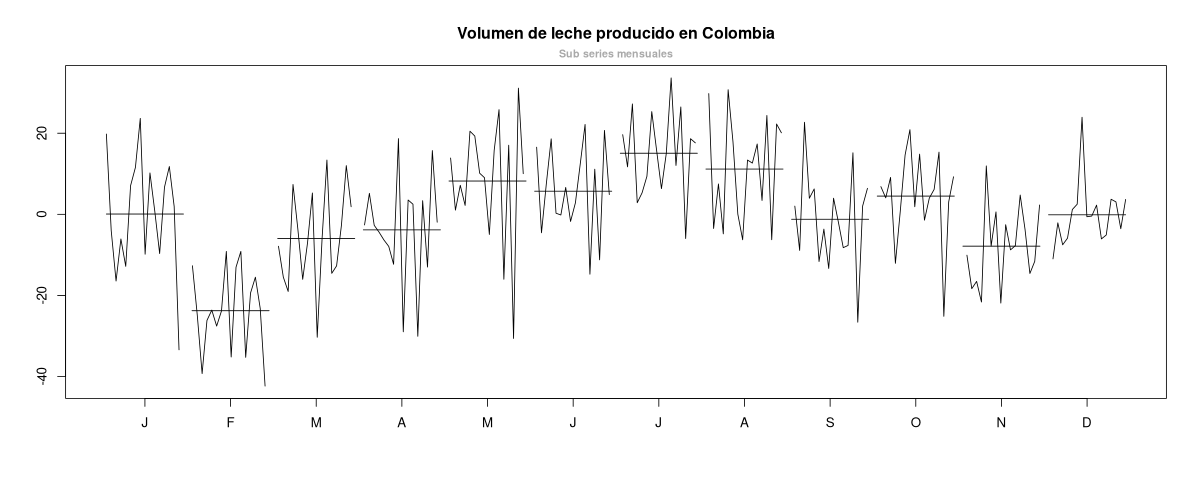

In [14]:
%%R -w 15 -h 6 --units in -r 80
monthplot(leche, ylab = '', main = 'Volumen de leche producido en Colombia')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

### 🐮🐮🐮 **Periodograma**

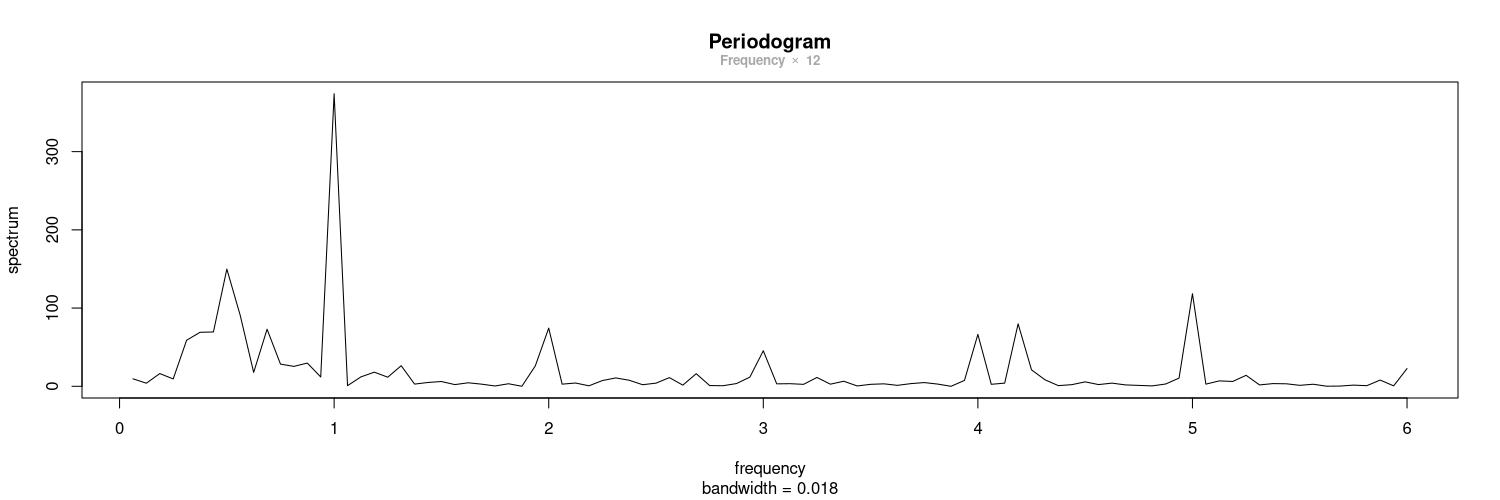

In [15]:
%%R -w 15 -h 5 --units in -r 100
SpectrumLeche = spectrum(leche, log = 'no', main = 'Periodogram')
mtext(latex2exp::TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Luego de probar distintos métodos, se decide utilizar variables dummys para intentar ajustar la estacionalidad de la serie. Los resultados se encuentran a continuación:

El valor máximo no. 1  en el que se máximiza el periodograma es 374.0577 
en la frecuencia  1 
El valor máximo no. 2  en el que se máximiza el periodograma es 149.8748 
en la frecuencia  0.5 
El valor máximo no. 3  en el que se máximiza el periodograma es 118.3689 
en la frecuencia  5 


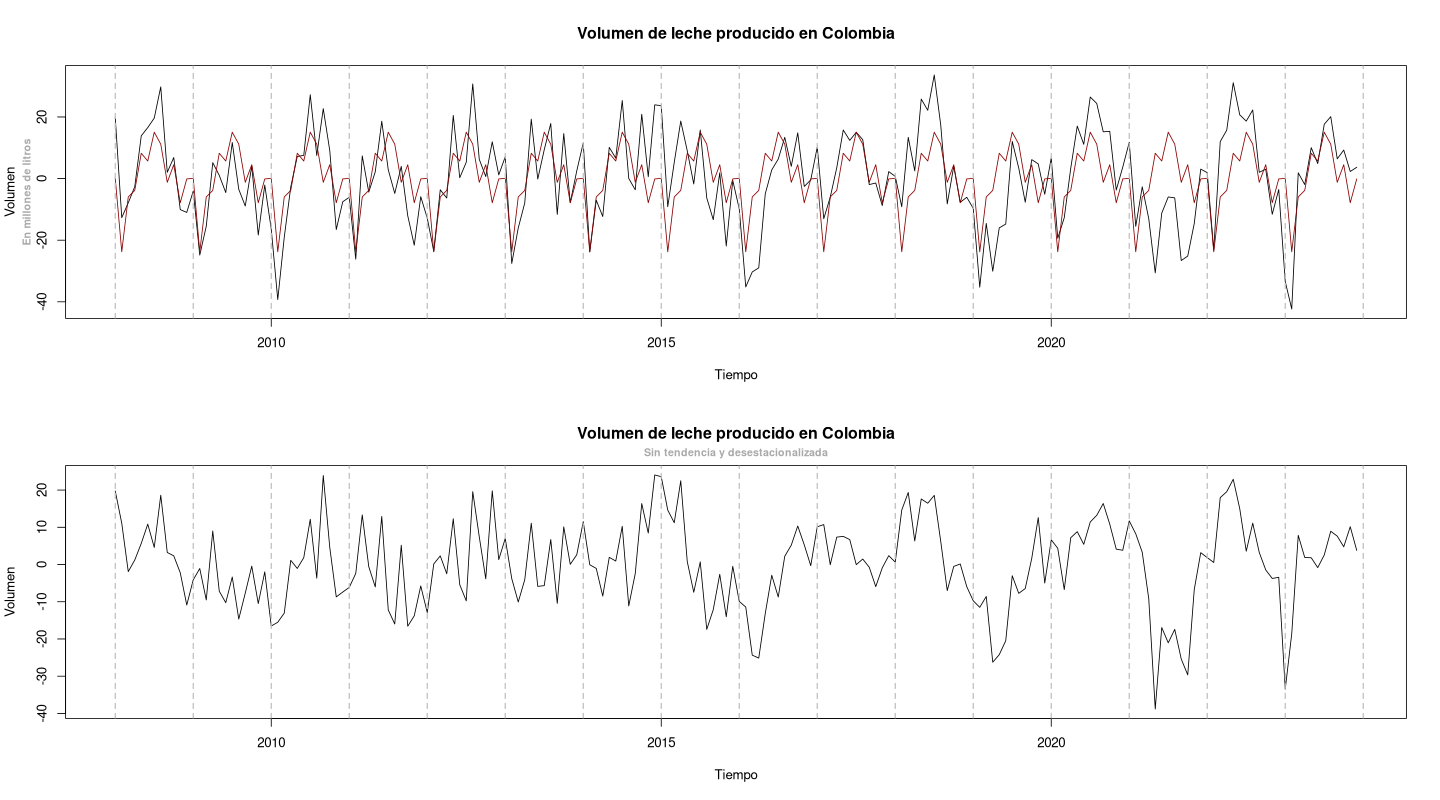

In [16]:
%%R -w 18 -h 10 --units in -r 80
source(paste0(Ruta, 'Script análisis/Leche: Estacionalidad.R'))

---

# 🐮 **Árboles de decisión**

Para los árboles de decisión, tendremos en cuenta lo encontrado en la sección anterior:

- Utilizaremos los datos sin tendencia ajustados antes con regresión Kernel.
- Como la serie cuenta con apenas 192 datos utilizaremos validación cruzada para ajustar hiperparámetros.
    -  Dejaremos 180 datos de entrenamiento y 12 datos de prueba.
- Antes de iniciar con cualquier código de python debemos cambiar el tipo de dato de `leche` de `array` a `pd.Series`

In [17]:
type(leche)

numpy.ndarray

In [18]:
date_index = pd.date_range(start = '2008-01', periods = len(leche), freq = 'M')
leche = pd.Series(leche, index = date_index)
leche

2008-01-31    19.795864
2008-02-29   -12.682066
2008-03-31    -7.872412
2008-04-30    -2.623688
2008-05-31    13.881874
                ...    
2023-08-31    20.100389
2023-09-30     6.408911
2023-10-31     9.259564
2023-11-30     2.303314
2023-12-31     3.667490
Freq: ME, Length: 192, dtype: float64

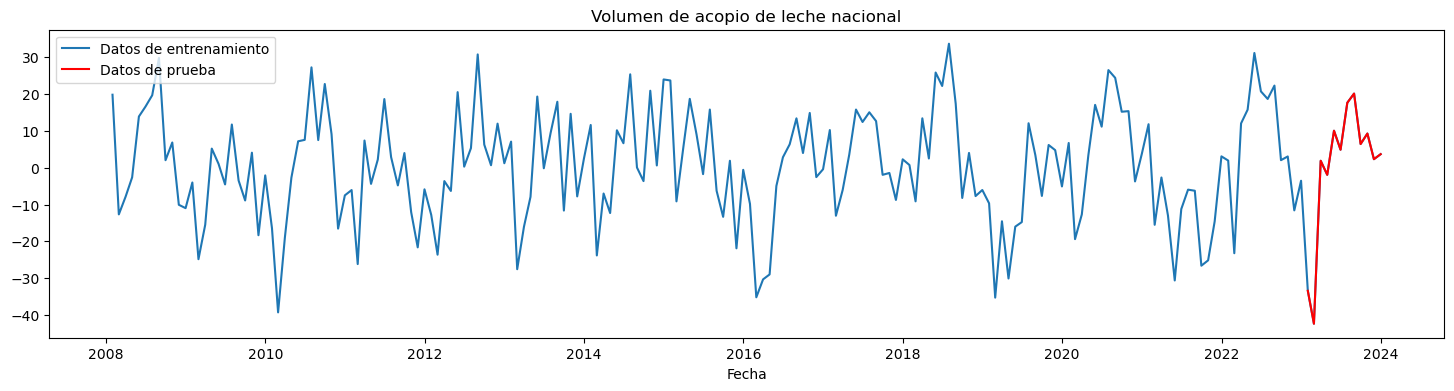

In [19]:
leche_train = leche[0:-12]
leche_test = leche[-12:len(leche)]
plot.figure(figsize = (18,4))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Leyenda
plot.title('Volumen de acopio de leche nacional')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

## 🐮🐮 **Selección de rezagos**

En cuanto al entrenamiento del árbol:
- Usaremos la función `ForecasterAutoreg` del paquete `skforecast.ForecasterAutoreg`.
- Además del rezago de 12 meses intentaremos agregar otros rezagos para revisar distintos árboles:
    - Del 1 al 12 de forma secuencial.
    - 1, 6 y 12 meses.
    - 1, 3, 6,9 y 12 meses.
    - 1 y 12 meses.
    - 6 y 12 meses.
    - 4, 8 y 12 meses.
- Un problema presentado a lo largo del entrenamiento del árbol usando `grid search` es  que si definimos `initial_sample_size` como el 50% de los datos, el árbol nos va a generar un árbol que no genera "ramas" por eso se define búsqueda de profundidades y un tamaño del conjunto de datos en cada hoja del árbol mínimo (En este caso de forma arbitraria, escogemos la mínima cantidad de muestras en base a el número de años del set de datos).

In [41]:
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
          [1,6,12],
          [1,3,6,9,12],
          [1,12],
          [6,12],
          [4,8,12]]
hiperparametros = {'max_depth': list(range(1, 15)), 
                  'min_samples_leaf': list(range(6,15))}
#hiperparametro = {'min_samples_leaf': list(range(1,15))}

Una vez definidos estos, creamos un árbol inicial:

In [42]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305),
    lags = 6 # Este valor posiblemente cambiará con la busquéda de hiperparámetros
)

Por el momento, sólo buscaremos los mejores modelos de árbol un paso adelante:

In [43]:
tuning = grid_search_forecaster(
    forecaster = tree_leche,
    y = leche_train,
    param_grid = hiperparametros,
    lags_grid = rezagos,
    steps = 1,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(leche_train) * 0.8),
    fixed_train_size = False,
    return_best = True,
    verbose = False)

Number of models compared: 2142.


lags grid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:50<00:00, 17.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 8}
  Backtesting metric: 125.9081336572329



El modelo que mejor se desempeña en el conjunto de entrenamiento es:

In [63]:
tuning = tuning.sort_values(by = ['mean_squared_error','max_depth'])
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf
425,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8
434,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 7, 'min_samples_leaf': 8}",125.908134,7,8
443,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",125.908134,8,8
452,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 9, 'min_samples_leaf': 8}",125.908134,9,8
461,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8
...,...,...,...,...,...,...
1973,"[6, 12]","[6, 12]","{'max_depth': 10, 'min_samples_leaf': 8}",386.675996,10,8
1982,"[6, 12]","[6, 12]","{'max_depth': 11, 'min_samples_leaf': 8}",386.675996,11,8
1991,"[6, 12]","[6, 12]","{'max_depth': 12, 'min_samples_leaf': 8}",386.675996,12,8
2000,"[6, 12]","[6, 12]","{'max_depth': 13, 'min_samples_leaf': 8}",386.675996,13,8


Como la idea es comparar entre rolling, back testing, filtro exponencial y modelos de redes neuronales entonces guardaremos el mejor modelo de cada uno de los métodos en tuning:

In [64]:
tuning = tuning[0:1]
tuning['Método'] = 'Rolling'
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf,Método
425,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8,Rolling


## 🐮🐮 **Modelo final**

Como el argumento en la búsqueda de grilla `refit_best` tiene como valor `True` no es necesario reajustar nuestro modelo pues el árbol ya está entrenado con los mejores hiperparámetros:

In [65]:
predicciones = tree_leche.predict(12)
predicciones

2023-01-31   -13.717527
2023-02-28   -22.050587
2023-03-31    -5.766836
2023-04-30    -1.052446
2023-05-31    -1.052446
2023-06-30    13.988646
2023-07-31    11.685102
2023-08-31    20.403882
2023-09-30    20.403882
2023-10-31     6.030851
2023-11-30    10.791264
2023-12-31    -9.962755
Freq: ME, Name: pred, dtype: float64

In [79]:
MSE = mean_squared_error(y_true = leche_test, y_pred =predicciones)

tuning['MSE test'] =  MSE

In [97]:
tuning

,lags,lags_label,params,mean_squared_error,max_depth,min_samples_leaf,Método,MSE test
425,"[1, 2, 3, 4]","[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",125.908134,6,8,Rolling,130.371382


## 🐮🐮 **Estructura del árbol**

El rezago más importante para la predicción en este caso es el primer rezago:

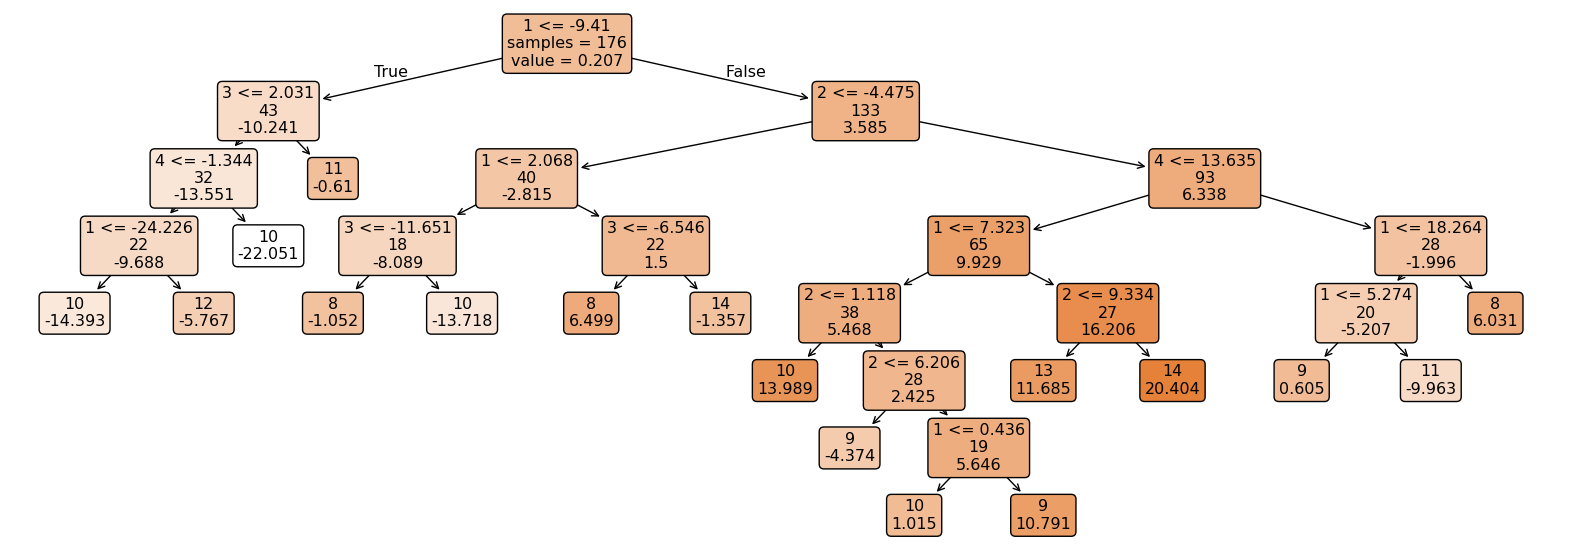

In [82]:
# Crear una visualización del árbol
plot.figure(figsize=(20,7))
plot_tree(tree_leche.regressor, #max_depth = 5,
          filled=True, feature_names=tree_leche.lags, rounded = True,
          impurity = False, label = 'root')
plot.show()

In [93]:
tree_leche.get_feature_importances()['importance']

0    0.508937
1    0.204687
3    0.176173
2    0.110203
Name: importance, dtype: float64

## 🐮🐮 **Usando backtesting**

Otra forma de ajustar el modelo es usando backtesting en cambio del rolling que se estaba haciendo. Así, ahora tenemos que dividir los datos de entrenamiento en entrenamiento y validación y volver a sjutar nuestro modelo:

In [103]:
help(backtesting_forecaster)

Help on function backtesting_forecaster in module skforecast.model_selection.model_selection:

backtesting_forecaster(forecaster: object, y: pandas.core.series.Series, steps: int, metric: Union[str, Callable, list], initial_train_size: Optional[int] = None, fixed_train_size: bool = True, gap: int = 0, skip_folds: Union[int, list, NoneType] = None, allow_incomplete_fold: bool = True, exog: Union[pandas.core.series.Series, pandas.core.frame.DataFrame, NoneType] = None, refit: Union[bool, int] = False, interval: Optional[list] = None, n_boot: int = 250, random_state: int = 123, in_sample_residuals: bool = True, binned_residuals: bool = False, n_jobs: Union[int, str] = 'auto', verbose: bool = False, show_progress: bool = True) -> Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]
    Backtesting of forecaster model.

    - If `refit` is `False`, the model will be trained only once using the
    `initial_train_size` first observations.
    - If `refit` is `True`, the model is t